In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import sklearn
import tensorflow as tf

In [2]:
# dataset percentage
valid_set_percent = 10
test_set_percent = 10

## Analyze Data

#### Load stock price data from prices-split-adjusted.csv

In [3]:
# all stock prices
df = pd.read_csv('prices-split-adjusted.csv', index_col=0)

In [4]:
df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
symbol    851264 non-null object
open      851264 non-null float64
close     851264 non-null float64
low       851264 non-null float64
high      851264 non-null float64
volume    851264 non-null float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB


In [6]:
print("Number of different stocks: ", len(list(set(df.symbol))))
print(list(set(df.symbol))[:10])

Number of different stocks:  501
['AN', 'COST', 'ESS', 'NWSA', 'HON', 'OMC', 'RCL', 'AIG', 'MJN', 'CBS']


In [7]:
df.tail()

,symbol,open,close,low,high,volume
date,,,,,,
2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0
2016-12-30,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0
2016-12-30,FTV,54.200001,53.630001,53.389999,54.480000,705100.0


In [8]:
df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [10]:
df.describe(include='O')

,symbol
count,851264
unique,501
top,XEL
freq,1762


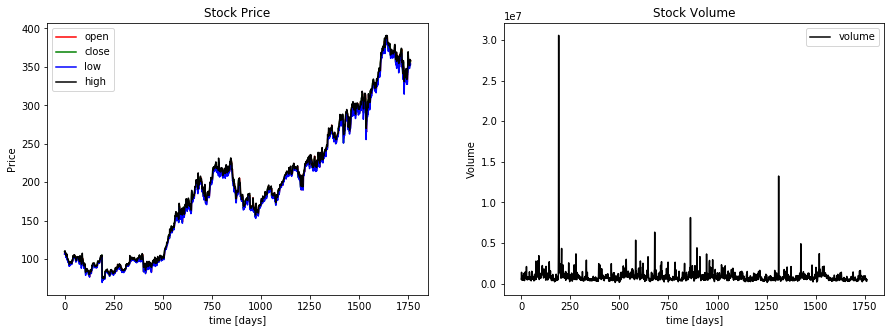

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(df[df.symbol=='EQIX'].open.values, color='red', label='open')
plt.plot(df[df.symbol=='EQIX'].close.values, color='green', label='close')

plt.plot(df[df.symbol=='EQIX'].low.values, color='blue', label='low')
plt.plot(df[df.symbol=='EQIX'].high.values, color='black', label='high')
plt.title('Stock Price')
plt.xlabel('time [days]')
plt.ylabel('Price')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(df[df.symbol=='EQIX'].volume.values, color='black', label='volume')
plt.title('Stock Volume')
plt.xlabel('time [days]')
plt.ylabel('Volume')
plt.legend(loc='best')

plt.show()

## Manipulate data 

* choose a specific stock
* drop feature: volume
* normalize stock data
* create train, validation and test data sets

In [24]:
# min-max normalization of stock
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
def normalize_data(df):
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df.close.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    return df


# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.values # convert to numpy array
    data = []
    
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index + seq_len])
        
    data = np.array(data)

    valid_set_size = int(np.round(data.shape[0]*valid_set_percent/100))
    test_set_size = int(np.round(data.shape[0]*test_set_percent/100))
    train_set_size = data.shape[0] - (valid_set_size + test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size, :-1, :]
    y_valid = data[train_set_size:train_set_size+valid_set_size, -1, :]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

In [25]:
# choose one stock
df_stock = df[df.symbol=='EQIX'].copy()
df_stock.drop(['symbol'], axis=1, inplace=True)
df_stock.drop(['volume'], axis=1, inplace=True)

In [26]:
cols = df_stock.columns.values
print("Stock columns: ", cols)

Stock columns:  ['open' 'close' 'low' 'high']


In [27]:
#normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock)

In [28]:
# create train test validatio data
seq_len=20
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1394, 19, 4)
y_train.shape =  (1394, 4)
x_valid.shape =  (174, 19, 4)
y_valid.shape =  (174, 4)
x_test.shape =  (174, 19, 4)
y_test.shape =  (174, 4)


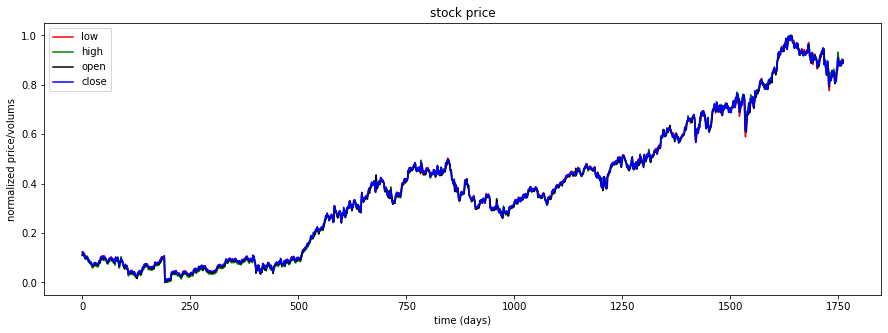

In [31]:
plt.figure(figsize=(15,5))
plt.plot(df_stock_norm.low.values, color='red', label='low')
plt.plot(df_stock_norm.high.values, color='green', label='high')
plt.plot(df_stock_norm.open.values, color='black', label='open')
plt.plot(df_stock_norm.close.values, color='blue', label='close')
plt.title("stock price")
plt.ylabel('normalized price/volums')
plt.xlabel('time (days)')
plt.legend(loc='best')
plt.show()

## Model and validate data RNNs with basic, LSTM, GRU cells

In [56]:
index_in_epoch= 0
perm_array= np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

#function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array)
        start=0
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

In [34]:
# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

from tensorflow.python.framework import ops
ops.reset_default_graph()

In [41]:
X = tf.compat.v1.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.compat.v1.placeholder(tf.float32, [None, n_outputs])

In [45]:
# use Basic RNN Cell
layers = [tf.keras.layers.SimpleRNNCell(units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

In [50]:
import keras
multi_layer_cell = tf.keras.layers.StackedRNNCells(layers)
rnn_outputs, states = tf.compat.v1.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [53]:
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence

In [54]:
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

In [57]:
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})

0.00 epochs: MSE train/valid = 1.318382/2.725610
4.99 epochs: MSE train/valid = 0.000380/0.001306
9.97 epochs: MSE train/valid = 0.000302/0.001257
14.96 epochs: MSE train/valid = 0.000177/0.000891
19.94 epochs: MSE train/valid = 0.000177/0.000795
24.93 epochs: MSE train/valid = 0.000183/0.000510
29.91 epochs: MSE train/valid = 0.000244/0.000549
34.90 epochs: MSE train/valid = 0.000132/0.000422
39.89 epochs: MSE train/valid = 0.000113/0.000416
44.87 epochs: MSE train/valid = 0.000115/0.000492
49.86 epochs: MSE train/valid = 0.000212/0.000812
54.84 epochs: MSE train/valid = 0.000116/0.000490
59.83 epochs: MSE train/valid = 0.000099/0.000428
64.81 epochs: MSE train/valid = 0.000160/0.000609
69.80 epochs: MSE train/valid = 0.000089/0.000310
74.78 epochs: MSE train/valid = 0.000090/0.000371
79.77 epochs: MSE train/valid = 0.000141/0.000339
84.76 epochs: MSE train/valid = 0.000119/0.000321
89.74 epochs: MSE train/valid = 0.000080/0.000286
94.73 epochs: MSE train/valid = 0.000130/0.000355
99.

## Predictions

In [58]:
y_train.shape

(1394, 4)

correct sign prediction for close - open price for train/valid/test: 0.32/0.36/0.39


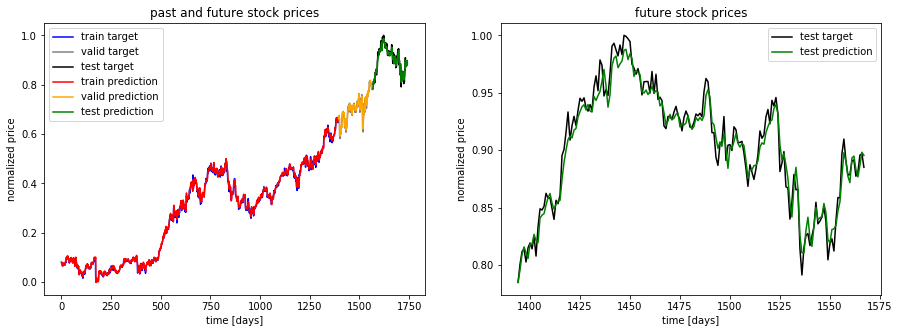

In [59]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

# show predictions
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))